### Copyright
**These notebooks, authored by Chun Fu and Hussain Kazmi, are accompanying material to the first Buildsys tutorial on load forecasting at building and urban scale. They are licensed under the AGPL License; you may not use this file except in compliance with the License. Notebooks are distributed on an “AS IS” BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.**

## Notebook 1: Exploratory analysis and modelling

This notebook provides an overview of exploratory data analysis of the dataset and how to develop forecast models based on this analysis.

To do so, we study the impact of several variables on the energy demand, and in creating our energy forecasts:

- Temporal features
- Weather-related features
- Calendar features (e.g. holidays etc.)
- Lagged features

We split the dataset into both training (01/2016 to 06/2016) and test data (07/2016 to 12-2016), and will develop and compare several different forecast models, including:

- Persistence model (copy values from last week as predictions)
- Linear model
- LightGBM model (one of the most popular regression model on Kaggle)

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import os
import tqdm
import requests
from datetime import datetime, timedelta
import time

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import lightgbm as lgb

## 2. Data reading and preprocessing

In this section, we load the dataset and convert it to a form that is more amenable to forecasting.

In [2]:
path_dataset=r'C:\Users\patri\Buildsys_Tutorial\dataset'
os.listdir(path_dataset)

['acorn_details.csv',
 'daily_dataset.csv',
 'darksky_parameters_documentation.html',
 'elec_block.csv',
 'elec_city.csv',
 'elec_house.csv',
 'halfhourly_dataset',
 'informations_households.csv',
 'uk_bank_holidays.csv',
 'weather_daily_darksky.csv',
 'weather_hourly_darksky.csv']

In [3]:
informations_households = pd.read_csv(os.path.join(path_dataset,'informations_households.csv'))
informations_households

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0
...,...,...,...,...,...
5561,MAC002056,Std,ACORN-U,ACORN-U,block_111
5562,MAC004587,Std,ACORN-U,ACORN-U,block_111
5563,MAC004828,Std,ACORN-U,ACORN-U,block_111
5564,MAC001704,ToU,ACORN-U,ACORN-U,block_111


### 2.1 Energy data

In [4]:
elec_house = pd.read_csv(os.path.join(path_dataset,'elec_house.csv'),index_col='tstp',parse_dates=True)
elec_house

,MAC000002,MAC000003,MAC000004,MAC000005,MAC000006,MAC000007,MAC000008,MAC000009,MAC000010,MAC000011,...,MAC005554,MAC005555,MAC005557,MAC005558,MAC005561,MAC005562,MAC005564,MAC005565,MAC005566,MAC005567
tstp,,,,,,,,,,,,,,,,,,,,,
2011-11-23 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-23 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-23 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-23 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-23 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 22:00:00,0.416,0.042,0.167,0.248,0.067,0.282,NaN,0.193,0.534,0.171,...,NaN,0.119,0.143,0.0,0.361,0.427,0.121,NaN,0.141,0.173
2014-02-27 22:30:00,1.350,0.117,0.000,0.113,0.047,0.346,NaN,0.338,0.478,0.145,...,NaN,0.062,0.125,0.0,0.088,0.336,0.135,NaN,0.123,0.205
2014-02-27 23:00:00,1.247,0.064,0.000,0.111,0.014,0.168,NaN,0.207,0.584,0.118,...,NaN,0.113,0.171,0.0,0.087,0.167,0.077,NaN,0.155,0.221


The elec_house dataframe is a 39727 x 5561 matrix, where each column is an individual household while each row is a time stamp. Not all households contain data for all time stamps (as evidenced by the several NaNs at the beginning of the dataframe). 

Next, let's take a look at some aggregations of 1, 10, 100 and 1000 households.

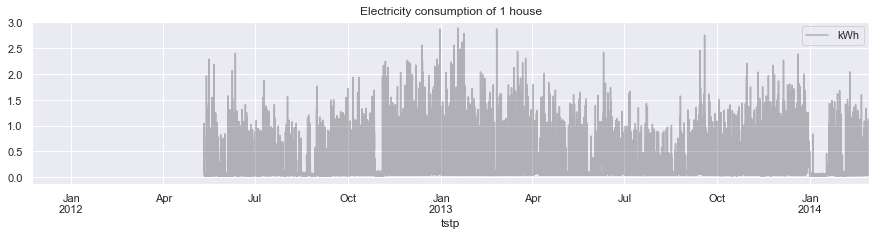

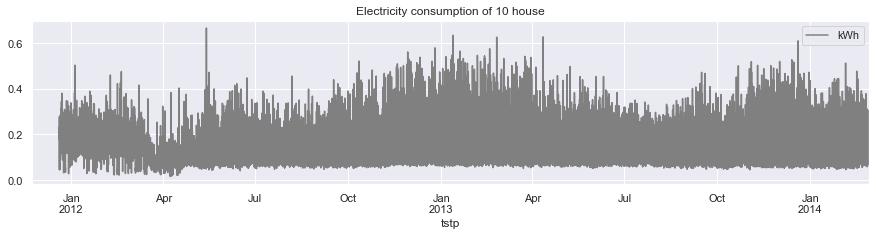

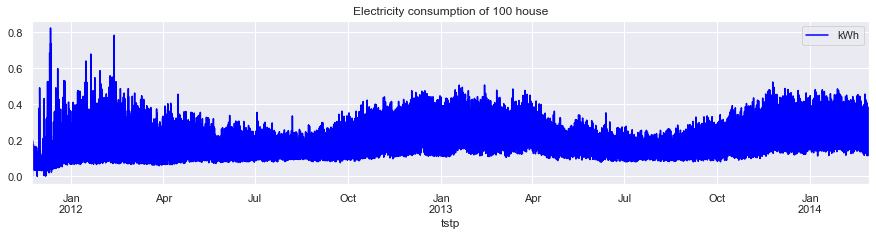

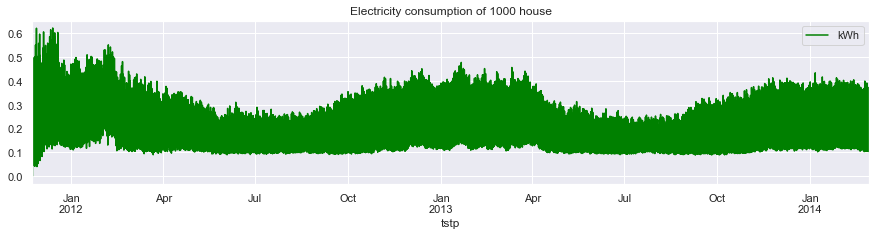

In [5]:
random_state = 1
elec_1house = elec_house.sample(n=1, random_state=random_state, axis=1)
elec_10house = elec_house.sample(n=10, random_state=random_state, axis=1).mean(axis=1).to_frame()
elec_100house = elec_house.sample(n=100, random_state=random_state, axis=1).mean(axis=1).to_frame()
elec_1000house = elec_house.sample(n=1000, random_state=random_state, axis=1).mean(axis=1).to_frame()

elec_1house.columns = ['kWh']
elec_10house.columns = ['kWh']
elec_100house.columns = ['kWh']
elec_1000house.columns = ['kWh']

elec_1house.plot(figsize=(15,3),color='black',alpha=0.25,title='Electricity consumption of 1 house');
plt.show();

elec_10house.plot(figsize=(15,3),color='grey',title='Electricity consumption of 10 house');
plt.show();

elec_100house.plot(figsize=(15,3),color='blue',title='Electricity consumption of 100 house');
plt.show();

elec_1000house.plot(figsize=(15,3),color='green',title='Electricity consumption of 1000 house');
plt.show();

Next, we try to better understand the extent of missing data in the dataframe.

Text(0.5, 1.0, 'Missing data in time series')

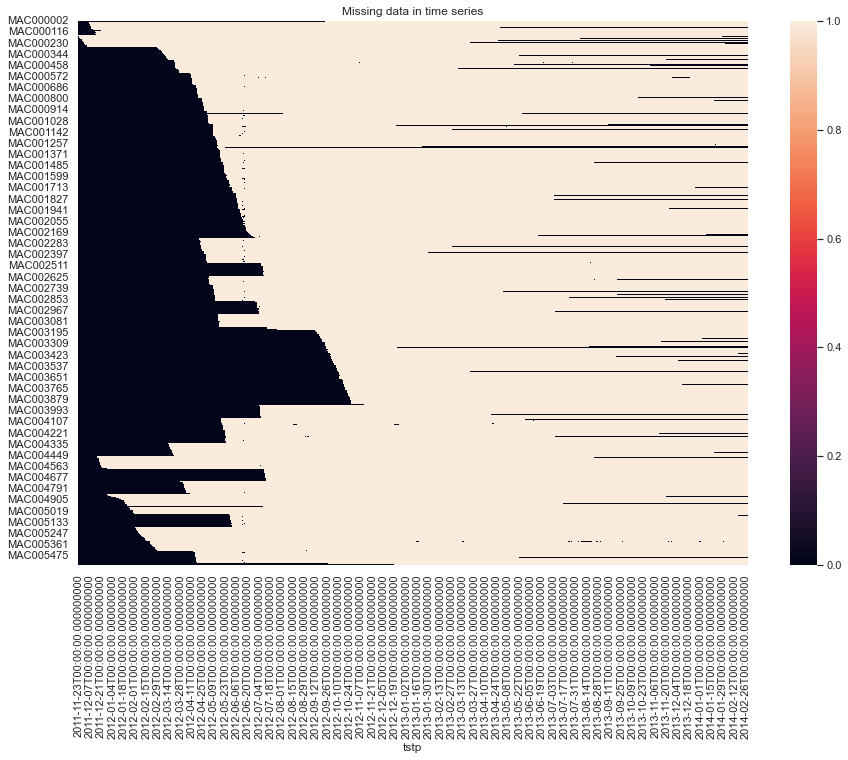

In [6]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(~elec_house.resample('D').mean().isna().T)
ax.set_title('Missing data in time series')

### 2.2 Weather data

In addition to the historic energy dataset, we also have access to weather conditions in the same region. These are from Darksky.

In [7]:
weather_hourly_darksky = pd.read_csv(os.path.join(path_dataset,'weather_hourly_darksky.csv'),index_col='time',parse_dates=True)
weather_hourly_darksky.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


<AxesSubplot:xlabel='time'>

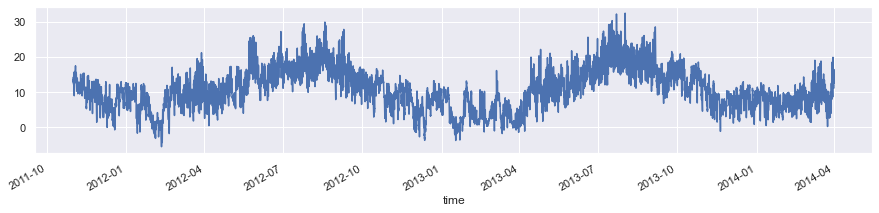

In [8]:
temperatureData = weather_hourly_darksky['temperature']
temperatureData.plot(figsize=(15,3))

### 2.3 Calendar data

Additionally, we can also load bank holidays in the UK for our analysis.

In [9]:
df_holiday = pd.read_csv(os.path.join(path_dataset,'uk_bank_holidays.csv'))
df_holiday['Bank holidays'] = pd.to_datetime(df_holiday['Bank holidays'])
df_holiday = df_holiday.rename(columns={'Bank holidays':'date','Type':'Holiday'})
df_holiday.head()

,date,Holiday
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [10]:
calendar_encoder = preprocessing.LabelEncoder()
df_holiday['Holiday'] = calendar_encoder.fit_transform(df_holiday['Holiday'])

df_holiday.head()

,date,Holiday
0,2012-12-26,0
1,2012-12-25,1
2,2012-08-27,10
3,2012-05-06,7
4,2012-04-06,9


## 3. Forecasting model of 1000-houses average electricity

Let's begin the forecasting process with making a dataframe which includes all the relevant features (weather, calendar and historic data).

In [11]:
df_dataset = elec_1000house.copy()

df_dataset['timestamp'] = df_dataset.index
df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData, left_index=True, right_index=True)
df_dataset['kWh_yesterday'] = df_dataset['kWh'].shift(24)
df_dataset['kWh_lastweek'] = df_dataset['kWh'].shift(7*24)

df_dataset = df_dataset.merge(df_holiday, on='date', how='left')
df_dataset = df_dataset.drop('date',axis=1)

df_dataset['Holiday'] = df_dataset['Holiday'].fillna(-1)

df_dataset.set_index('timestamp',inplace=True)

df_dataset = df_dataset.dropna()

df_dataset

,kWh,year,weekday,hour,timeofweek,temperature,kWh_yesterday,kWh_lastweek,Holiday
timestamp,,,,,,,,,
2011-11-30 10:00:00,0.361636,2011,2,10.0,58.0,9.73,0.107857,0.054000,-1.0
2011-11-30 11:00:00,0.214545,2011,2,11.0,59.0,11.29,0.165000,0.064000,-1.0
2011-11-30 12:00:00,0.342333,2011,2,12.0,60.0,11.87,0.176875,0.064000,-1.0
2011-11-30 13:00:00,0.196917,2011,2,13.0,61.0,11.67,0.324889,0.064000,-1.0
2011-11-30 14:00:00,0.169500,2011,2,14.0,62.0,11.81,0.164667,0.000000,-1.0
...,...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,0.344938,2014,3,20.0,92.0,5.94,0.367868,0.349658,-1.0
2014-02-27 21:00:00,0.347253,2014,3,21.0,93.0,5.03,0.333826,0.326316,-1.0
2014-02-27 22:00:00,0.304747,2014,3,22.0,94.0,4.10,0.296397,0.307496,-1.0


### 3.1 Our 1st model: temporal feature

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='timeofweek', ylabel='kWh'>

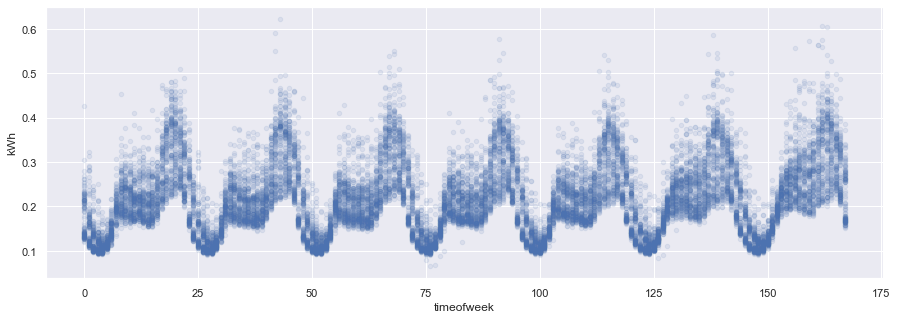

In [12]:
df_dataset.plot(kind='scatter',x='timeofweek',y='kWh', figsize=(15,5),alpha=0.1)

In [13]:
list_feat = ['weekday','hour']

In [14]:
def testdata_plot(df):
    plt.figure(figsize=(15,2))
    plt.plot(df.loc['2013-8'].index, df.loc['2013-8','kWh'], '-k', alpha=0.6, label='kWh')
    plt.plot(df.loc['2013-8'].index, df.loc['2013-8','kWh_pred'], '--g', alpha=0.8, label='kWh_pred')
    plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))
    plt.show() 
    print("------------------------------------------------")
    status = True
    return None

Next, let's create three models (persistence, linear and LGBM) using just the weekday and hour as the feature set.

Model: Persistent model
R SQUARED: 0.9365
MAE: 0.0125


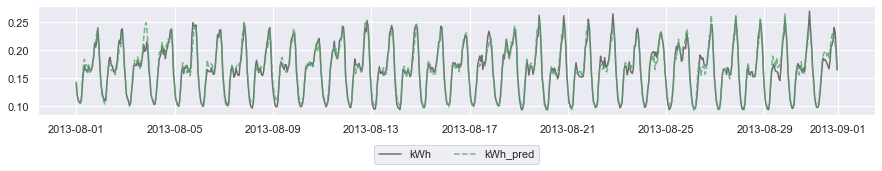

------------------------------------------------
Model: Linear regression
R SQUARED: 0.4764
MAE: 0.045


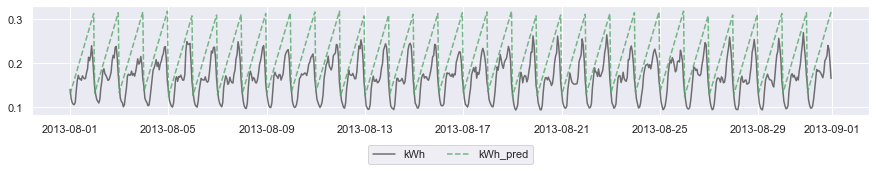

------------------------------------------------
Model: LGBM
R SQUARED: 0.6956
MAE: 0.0329


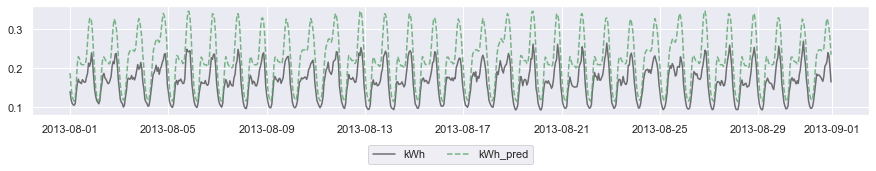

------------------------------------------------


In [15]:
traindata = df_dataset.loc['2013-01':'2013-06'].copy()
testdata = df_dataset.loc['2013-07':].copy()

testdata['kWh_pred'] = testdata['kWh_lastweek']
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Persistent model")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

LR_model = LinearRegression()
LR_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LR_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Linear regression")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)


LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

The persistence model is already doing pretty well. On the other hand, the learning algorithms are not the best. 

### 3.2 The 2nd model: add weather feature

Let's next check how the load relates to temperature.

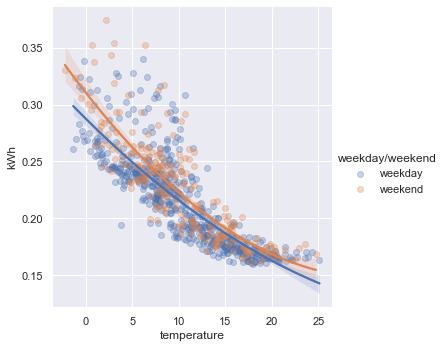

In [16]:
# Scatter plot for demand and outdoor temperature
df_plot = df_dataset.resample('D').mean().copy()
df_plot['weekday/weekend'] = 'weekday'
df_plot.loc[df_plot['weekday']>4, 'weekday/weekend'] ='weekend'

sns.lmplot(x='temperature', y='kWh', hue="weekday/weekend",
           data=df_plot, order=2, scatter_kws={'alpha':0.3})

We can combine all three features together now!

In [17]:
list_feat = ['weekday','hour','temperature']

Model: Persistent model
R SQUARED: 0.9365
MAE: 0.0125


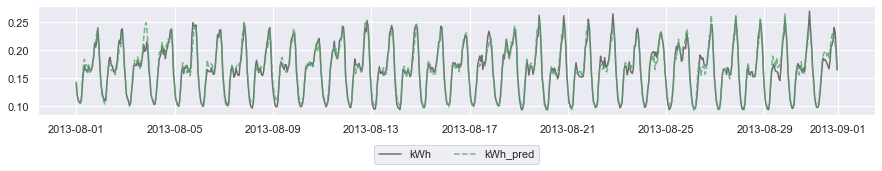

------------------------------------------------
Model: Linear regression
R SQUARED: 0.6238
MAE: 0.0362


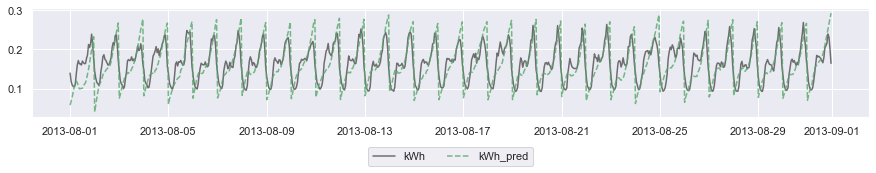

------------------------------------------------
Model: LGBM
R SQUARED: 0.893
MAE: 0.0168


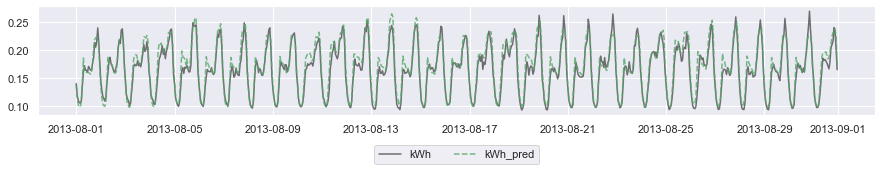

------------------------------------------------


In [18]:
traindata = df_dataset.loc['2013-01':'2013-06'].copy()
testdata = df_dataset.loc['2013-07':].copy()

testdata['kWh_pred'] = testdata['kWh_lastweek']
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Persistent model")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

LR_model = LinearRegression()
LR_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LR_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Linear regression")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

The persistence model is obviously unchanged, but the linear and LGBM models are also doing a bit better now. Let's see if we can further improve these models using the holiday feature as well.

### 3.3 The 3rd model: add calendar data

In [19]:
list_feat = ['weekday','hour','temperature',
             'Holiday']

Model: Persistent model
R SQUARED: 0.9365
MAE: 0.0125


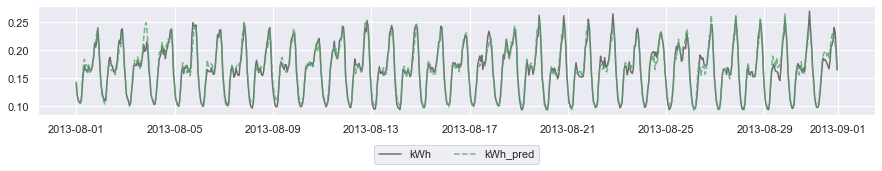

------------------------------------------------
Model: Linear regression
R SQUARED: 0.6238
MAE: 0.0362


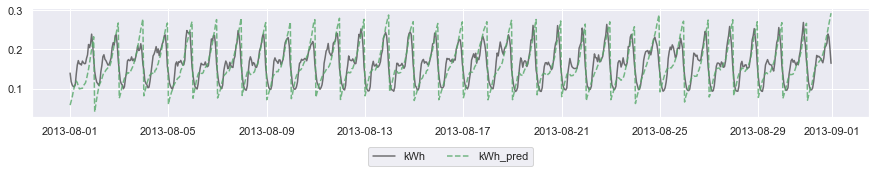

------------------------------------------------
Model: LGBM
R SQUARED: 0.8935
MAE: 0.0168


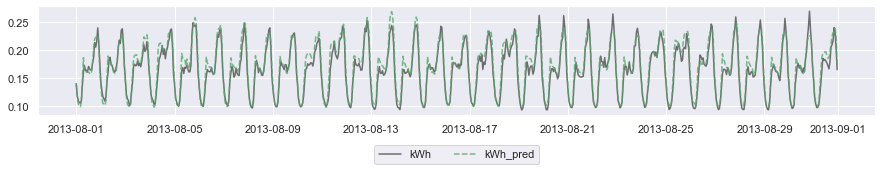

------------------------------------------------


In [20]:
traindata = df_dataset.loc['2013-01':'2013-06'].copy()
testdata = df_dataset.loc['2013-07':].copy()

testdata['kWh_pred'] = testdata['kWh_lastweek']
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Persistent model")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

LR_model = LinearRegression()
LR_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LR_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Linear regression")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

That did not lead to any significant improvement, but perhaps the historical energy demand will improve the forecasts.

### 3.4 The 4th model: add lag feature

In [21]:
list_feat = ['weekday','hour','temperature',
             'Holiday',
             'kWh_yesterday']

Model: Persistent model
R SQUARED: 0.9365
MAE: 0.0125


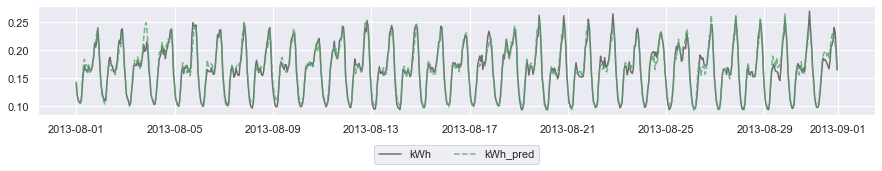

------------------------------------------------
Model: Linear regression
R SQUARED: 0.9367
MAE: 0.0133


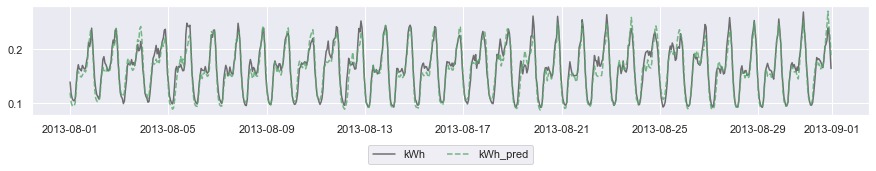

------------------------------------------------
Model: LGBM
R SQUARED: 0.9635
MAE: 0.0098


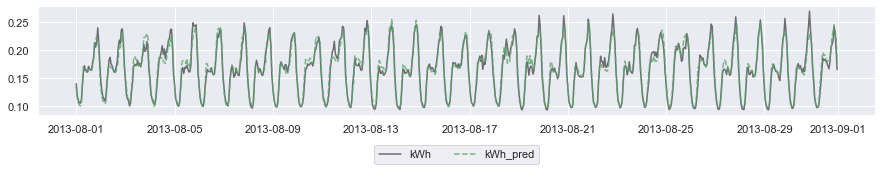

------------------------------------------------


In [22]:
traindata = df_dataset.loc['2013-01':'2013-06'].copy()
testdata = df_dataset.loc['2013-07':].copy()

testdata['kWh_pred'] = testdata['kWh_lastweek']
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Persistent model")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

LR_model = LinearRegression()
LR_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LR_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: Linear regression")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['kWh'])
testdata['kWh_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['kWh_pred'] - testdata['kWh'])
RSQUARED = r2_score(testdata['kWh'], testdata['kWh_pred'])
MAE = mean_absolute_error(testdata['kWh'], testdata['kWh_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))
testdata_plot(testdata)

That worked like a charm, and the LGBM outperforms the peristence model. Adding further features (greater lag, other weather features etc.) can further improve the model performance.